In [1]:
import numpy as np
import scipy
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
import sys
import time
import matplotlib.pyplot as plt

In [2]:
def inputdata(fnameR, nod, nfree):  #データパス, 要素節点数, 自由度
    f = open(fnameR, 'r')
    text = f.readline()  # コメント
    text = f.readline()  # 1行ずつ読み込む
    text = text.strip()  # 端の空白, 改行(\n)を削除
    text = text.split()  # ','　で別れた要素ごとの配列にする
    npoin = int(text[0])  # ノード数
    nele = int(text[1])  # 要素数
    npfix = int(text[2])  # 拘束点数
    nlod = int(text[3])  # 荷重点数
    delta_t = float(text[4])  # 微小時間
    n_t = int(text[5])  # 微小時間数
    # 配列宣言
    ae = np.zeros((11, nele), dtype=np.float64)  # 要素特性
    node = np.zeros((nod + 1, nele), dtype=np.int)  # 要素構成節点
    x = np.zeros((3, npoin), dtype=np.float64)  # 座標
    mpfix = np.zeros((n_t + 1, nfree, npoin), dtype=np.int)  # 拘束状態
    rdis = np.zeros((n_t + 1, nfree, npoin), dtype=np.float64)  # 既知変位
    fp = np.zeros((n_t + 1, nfree * npoin), dtype=np.float64)  # 外力
    # 要素特性: ae
    text = f.readline()  # コメント
    for i in range(0, nele):
        text = f.readline()
        text = text.strip()
        text = text.split()
        ae[0, i] = float(text[0])  # E
        ae[1, i] = float(text[1])  # Po
        ae[2, i] = float(text[2])  # A
        ae[3, i] = float(text[3])  # Ix
        ae[4, i] = float(text[4])  # Iy
        ae[5, i] = float(text[5])  # Iz
        ae[6, i] = float(text[6])  # density
        ae[7, i] = float(text[7])  # gkx
        ae[8, i] = float(text[8])  # gky
        ae[9, i] = float(text[9])  # gkz

    text = f.readline()  # コメント
    # 要素構成節点: node
    for i in range(0, nele):
        text = f.readline()
        text = text.strip()
        text = text.split()
        node[0, i] = int(text[0])  #node_1
        node[1, i] = int(text[1])  #node_2
        node[2, i] = int(text[2])  #要素番号

    text = f.readline()  # コメント
    # 座標: x
    for i in range(0, npoin):
        text = f.readline()
        text = text.strip()
        text = text.split()
        x[0, i] = float(text[0])  # x-座標
        x[1, i] = float(text[1])  # y-座標
        x[2, i] = float(text[2])  # z-座標
    
    # 要素質量
    for i in range(0, nele):
        node1_x = x[0, i]
        #         node1_y = x[1, i]
        #         node1_z = x[2, i]
        node2_x = x[0, i + 1]
        #         node2_y = x[1, i+1]
        #         node2_z = x[2, i+1]
        A = ae[2, i]
        density = ae[6, i]
        ae[10, i] = abs(node1_x - node2_x) * A * density
        
#     for j in range(0, n_t+1):

    text = f.readline()  # コメント
    # 境界条件（拘束状態） (0:free, 1:restricted)
    for i in range(0, npfix):
        text = f.readline()
        text = text.strip()
        text = text.split()
        lp = int(text[0])  # 固定されたノード番号
        for j in range(0, n_t + 1):
            mpfix[j, 0, lp - 1] = int(text[1])  # x方向固定
            mpfix[j, 1, lp - 1] = int(text[2])  # y方向固定
            mpfix[j, 2, lp - 1] = int(text[3])  # z方向固定
            mpfix[j, 3, lp - 1] = int(text[4])  # x軸回転固定
            mpfix[j, 4, lp - 1] = int(text[5])  # y軸回転固定
            mpfix[j, 5, lp - 1] = int(text[6])  # z軸回転固定
            rdis[j, 0, lp - 1] = float(text[7])  # x方向既知変位
            rdis[j, 1, lp - 1] = float(text[8])  # y方向既知変位
            rdis[j, 2, lp - 1] = float(text[9])  # z方向既知変位
            rdis[j, 3, lp - 1] = float(text[10])  # x軸既知回転量
            rdis[j, 4, lp - 1] = float(text[11])  # y軸既知回転量
            rdis[j, 5, lp - 1] = float(text[12])  # z軸既知回転量

    text = f.readline()  # コメント
    # 荷重
    for i in range(0, nlod):
        text = f.readline()
        text = text.strip()
        text = text.split()
        lp = int(text[0])
        for j in range(0, n_t + 1):
            fp[j, 6 * lp - 6] = float(text[1])  # x方向荷重
            fp[j, 6 * lp - 5] = float(text[2])  # y方向荷重
            fp[j, 6 * lp - 4] = float(text[3])  # z方向荷重
            fp[j, 6 * lp - 3] = float(text[4])  # x軸モーメント
            fp[j, 6 * lp - 2] = float(text[5])  # y軸モーメント
            fp[j, 6 * lp - 1] = float(text[6])  # z軸モーメント
    f.close()
    return npoin, nele, npfix, nlod, delta_t, n_t, ae, node, x, mpfix, rdis, fp

In [20]:
npoin,nele,npfix,nlod,delta_t,n_t,ae,node,x,mpfix,rdis,fp=inputdata('test_verification1.txt',2, 6)

In [24]:
mass_mat = mass_3dfrm(ae[10], npoin, 6)
inv_mass_mat = np.linalg.inv(mass_mat)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0.])

In [3]:
# 要素剛性マトリックス作成（local）
def sm_3dfrm(EA,GJ,EIy,EIz,x1,y1,z1,x2,y2,z2):
    ek=np.zeros((12,12),dtype=np.float64) # local stiffness matrix
    xx=x2-x1
    yy=y2-y1
    zz=z2-z1
    el=np.sqrt(xx**2+yy**2+zz**2)
    ek[ 0, 0]= EA/el
    ek[ 0, 6]=-EA/el
    ek[ 1, 1]= 12*EIz/el**3
    ek[ 1, 5]=  6*EIz/el**2
    ek[ 1, 7]=-12*EIz/el**3
    ek[ 1,11]=  6*EIz/el**2
    ek[ 2, 2]= 12*EIy/el**3
    ek[ 2, 4]= -6*EIy/el**2
    ek[ 2, 8]=-12*EIy/el**3
    ek[ 2,10]= -6*EIy/el**2
    ek[ 3, 3]= GJ/el
    ek[ 3, 9]=-GJ/el
    ek[ 4, 2]= -6*EIy/el**2
    ek[ 4, 4]=  4*EIy/el
    ek[ 4, 8]=  6*EIy/el**2
    ek[ 4,10]=  2*EIy/el
    ek[ 5, 1]=  6*EIz/el**2
    ek[ 5, 5]=  4*EIz/el
    ek[ 5, 7]= -6*EIz/el**2
    ek[ 5,11]=  2*EIz/el
    ek[ 6, 0]=-EA/el
    ek[ 6, 6]= EA/el
    ek[ 7, 1]=-12*EIz/el**3
    ek[ 7, 5]= -6*EIz/el**2
    ek[ 7, 7]= 12*EIz/el**3
    ek[ 7,11]= -6*EIz/el**2
    ek[ 8, 2]=-12*EIy/el**3
    ek[ 8, 4]=  6*EIy/el**2
    ek[ 8, 8]= 12*EIy/el**3
    ek[ 8,10]=  6*EIy/el**2
    ek[ 9, 3]=-GJ/el
    ek[ 9, 9]= GJ/el
    ek[10, 2]= -6*EIy/el**2
    ek[10, 4]=  2*EIy/el
    ek[10, 8]=  6*EIy/el**2
    ek[10,10]=  4*EIy/el
    ek[11, 1]=  6*EIz/el**2
    ek[11, 5]=  2*EIz/el
    ek[11, 7]= -6*EIz/el**2
    ek[11,11]=  4*EIz/el
    return ek

In [4]:
def mass_3dfrm(ae_mass, npoin, nfree):
    # 番兵追加
    mass = np.append(ae_mass, 0.0)
    mass = np.insert(mass, 0, 0.0)
    ret = np.eye(npoin*nfree, dtype=np.float64)
    for i in range(0, len(mass) - 1):
        node_mass = (mass[i] + mass[i+1]) / 2.0
        for j in range(0, nfree):
            idx = i*nfree + j
            ret[idx,idx] *= node_mass
    return ret

In [5]:
def dumping_3dfrm(gamma, omega, mass_mat, gk):
    m = gamma * mass_mat
    gk = omega * gk    
    for i in range(0, len(gk)):
        gk[i, i] += m[i, i]        
    return gk

In [6]:
def back_3dfrm(delta_t, gk, mass_mat, c_mat):
    return delta_t*gk + (1.0/delta_t)*mass_mat + c_mat

In [11]:
def main_3d_back():
    start=time.time()
    args = sys.argv
    fnameR=args[1]
    fnameW=args[2]
    nod=2
    nfree=6
    alpha=0.5 # newmark param
    beta=0.25 # newmark param
    gamma=0.01 # dumping param
    omega=0.01 # dumping param
    npoin,nele,npfix,nlod,delta_t,n_t,ae,node,x,mpfix,rdis,fp=inputdata('test_verification1.txt',nod,nfree)
    mass_mat=mass_3dfrm(ae[10], npoin, nfree)
    inv_mass_mat=np.linalg.inv(mass_mat)
    vec=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)
    dis=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)
    for step in range(1, n_t+1):
        ir=np.zeros(nod*nfree, dtype=np.int) 
        gk=np.zeros((nfree*npoin, nfree*npoin), dtype=np.float64) # Global stifness matrix

        # assembly stifness matrix & load vector
        for ne in range(0, nele):
            i=node[0,ne]-1
            j=node[1,ne]-1
            m=node[2,ne]-1
            x1=x[0,i]; y1=x[1,i]; z1=x[2,i]
            x2=x[0,j]; y2=x[1,j]; z2=x[2,j]
            ee   =ae[0,m]  # elastic modulus
            po   =ae[1,m]  # Poisson's ratio
            aa   =ae[2,m]  # section area
            aix  =ae[3,m]  # tortional constant
            aiy  =ae[4,m]  # moment of inertia around y-axis
            aiz  =ae[5,m]  # moment of inertia around z-axis
            den  =ae[6,m]  # unit density of material
            gkX  =ae[7,m]  # seismic coefficient in X-direction
            gkY  =ae[8,m]  # seismic coefficient in Y-direction
            gkZ  =ae[9,m]  # seismic coefficient in Z-direction
            A=aa  # section area
            EA=ee*aa
            GJ=ee/2/(1+po)*aix
            EIy=ee*aiy
            EIz=ee*aiz
            ek=sm_3dfrm(EA,GJ,EIy,EIz,x1,y1,z1,x2,y2,z2) # local stiffness matrix                                
            ir[11]=6*j+5; ir[10]=ir[11]-1; ir[9]=ir[10]-1; ir[8]=ir[9]-1; ir[7]=ir[8]-1; ir[6]=ir[7]-1
            ir[5] =6*i+5; ir[4] =ir[5]-1 ; ir[3]=ir[4]-1 ; ir[2]=ir[3]-1; ir[1]=ir[2]-1; ir[0]=ir[1]-1                
            # assemble
            for i in range(0, nod*nfree):
                it=ir[i]
                for j in range(0, nod*nfree):
                    jt=ir[j]
                    gk[it, jt] = gk[it, jt] + ek[i,j]            

        c_mat=dumping_3dfrm(gamma, omega, mass_mat, gk)
        back_mat = back_3dfrm(delta_t, gk, mass_mat, c_mat)        
        fp[step] = np.dot((1.0/delta_t)*mass_mat+c_mat, dis[step-1]) \
            + np.dot(mass_mat, vec[step-1]) \
            + delta_t*fp[step]
        # boudary conditions
        for i in range(0, npoin):
            for j in range(0, nfree):
                if mpfix[step, j, i] == 1:                        
                    iz=i*nfree+j
                    fp[step,iz]=0.0

        for i in range (0, npoin):
            for j in range(0, nfree):
                if mpfix[step, j, i] == 1:
                    iz=i*nfree+j
                    back_mat[:,iz]=0.0
                    back_mat[iz,iz]=1.0
        # 疎行列圧縮格納        
        sp_back_mat = csr_matrix(back_mat)
        dis[step] = spsolve(back_mat, fp[step], use_umfpack=True)

        # 拘束条件を再代入する
        for i in range(0, npoin):
            for j in range(0, nfree):
                if mpfix[step, j, i] == 1:
                    iz=i*nfree+j
                    dis[step, iz] = rdis[step, j, i]
        vec[step] = (dis[step] - dis[step-1]) / delta_t
    # print out result
    dtime=time.time()-start
    print('time: {0:.3f}'.format(dtime)+'sec')
    return dis, vec

In [12]:
dis, vec = main_3d_back()

time: 5.292sec


In [13]:
check = np.empty((1000), dtype=np.float64)
for i in range(0, 1000):
    check[i] = dis[i, 22 * 6 + 2]

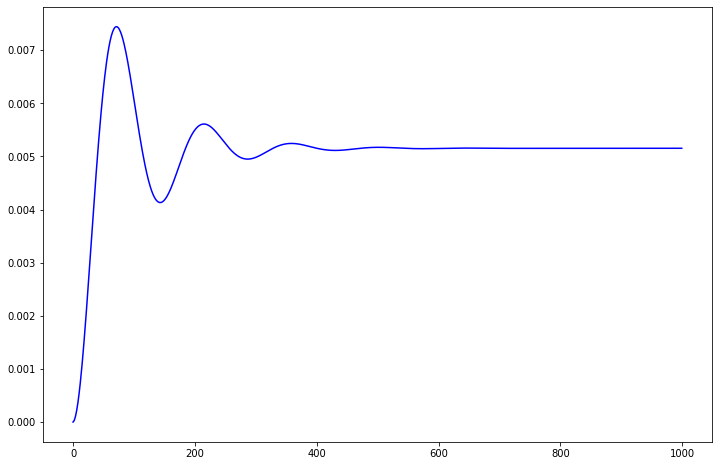

In [14]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(check, label='back_verif', color=(0, 0, 1))
plt.savefig('back_verif.png')
plt.show()


In [31]:
print(check)

[0.00000000e+00 1.10756279e-05 3.26203929e-05 6.42438346e-05
 1.05578963e-04 1.56268312e-04 2.15957631e-04 2.84292574e-04
 3.60916918e-04 4.45471629e-04 5.37594441e-04 6.36919767e-04
 7.43078818e-04 8.55699872e-04 9.74408636e-04 1.09882869e-03
 1.22858197e-03 1.36328929e-03 1.50257091e-03 1.64604708e-03
 1.79333864e-03 1.94406762e-03 2.09785782e-03 2.25433545e-03
 2.41312968e-03 2.57387326e-03 2.73620314e-03 2.89976098e-03
 3.06419381e-03 3.22915451e-03 3.39430240e-03 3.55930372e-03
 3.72383219e-03 3.88756947e-03 4.05020561e-03 4.21143950e-03
 4.37097932e-03 4.52854287e-03 4.68385799e-03 4.83666285e-03
 4.98670634e-03 5.13374824e-03 5.27755959e-03 5.41792286e-03
 5.55463212e-03 5.68749331e-03 5.81632427e-03 5.94095495e-03
 6.06122742e-03 6.17699600e-03 6.28812725e-03 6.39449999e-03
 6.49600527e-03 6.59254636e-03 6.68403864e-03 6.77040955e-03
 6.85159844e-03 6.92755645e-03 6.99824636e-03 7.06364237e-03
 7.12372997e-03 7.17850565e-03 7.22797674e-03 7.27216106e-03
 7.31108676e-03 7.344791

In [7]:
b = np.eye((3), dtype=np.float64)
b

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])